In [45]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms

In [46]:
train_set = torchvision.datasets.EMNIST(
    root='./data'
    ,train=True
    ,download=True
,split = 'byclass'
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

#emnist_test = datasets.EMNIST(root,split = 'balanced', train=False, download=True, transform = transform_valid)
test_set = torchvision.datasets.EMNIST(
    root='./data'
    ,train=False
    ,download=True
    ,split = 'byclass'
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [47]:
len(train_set)

697932

In [48]:
len(test_set)

116323

torch.Size([1, 28, 28])


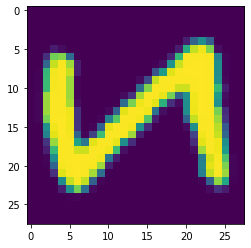

In [49]:
import matplotlib.pyplot as plt

image,label = train_set[0]
print(image.shape)

plt.imshow(image.squeeze())

In [50]:
train_set.train_labels.unique()

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61])

In [51]:
train_set.train_labels.bincount()

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([34585, 38374, 34203, 35143, 33535, 31416, 34232, 35754, 33946, 33847,
         6407,  3878, 10094,  4562,  4934,  9182,  2517,  3152, 11946,  3762,
         2468,  5076,  9002,  8237, 24983,  8347,  2605,  5073, 20764,  9820,
        12602,  4637,  4695,  2771,  4743,  2701, 10033,  5159,  2854, 10177,
        24631,  2561,  3687,  8738,  2725,  1896,  2491, 15318,  2645, 11418,
         2749,  2448,  2994, 14105,  2699, 18262,  2830,  2910,  2697,  2822,
         2365,  2725])

In [52]:
train_loader = torch.utils.data.DataLoader(train_set 
          , batch_size = 32
          , shuffle = True )
test_loader = torch.utils.data.DataLoader(test_set 
          , batch_size = 32)

In [53]:
for images, labels in train_loader:
  break

In [54]:
images.min() , images.max()

(tensor(0.), tensor(1.))

labels: tensor([ 8, 18, 39, 53,  6])


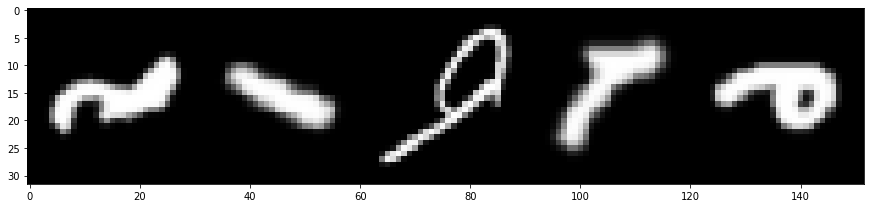

In [55]:
import numpy as np

grid = torchvision.utils.make_grid(images[:5], nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', labels[:5])

In [62]:
## NETWORK

import torch.nn.functional as F
import torch.nn as nn
"""
6 Convolution layers with these kernels (10, 10, 20, 20, 30)
no fully connected layer (you probably may have to use the Global Average Pooling layer)
uses EMNIST as the dataset
uses a maximum of 2 max-pooling layers

"""

class Network(nn.Module):
    def __init__(self):
        
        super().__init__()
        # super(Network,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3,bias =False )   ## 28 > 26 RF:3
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3 ,bias =False) ## 26 > 24 RF:5
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3 ,bias =False) ## 24 > 22 RF: 7
        self.pool1 = nn.MaxPool2d(2, 2) ## 22 > 11 RF:8

        self.conv4 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3,bias =False ) ## 11 > 9 RF: 12
        self.conv5 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3,bias =False) ## 9 > 7 RF: 16
        self.conv6 = nn.Conv2d(in_channels=30, out_channels=62, kernel_size=3,bias =False) ## 7 > 5  RF: 20
        
        self.out = nn.AdaptiveAvgPool2d(1) ## 6 > 1 RF: 30

    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv4(x)
        x = F.relu(x)

        x = self.conv5(x)
        x = F.relu(x)

        x = self.conv6(x)
        x = F.relu(x)

        x = self.out(x)
        x = F.softmax(x.view(-1,62), dim=1)

        return x

In [63]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [64]:
from torchsummary import summary

# model = Net().to(device)
model = Network().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
            Conv2d-2           [-1, 10, 24, 24]             900
            Conv2d-3           [-1, 20, 22, 22]           1,800
         MaxPool2d-4           [-1, 20, 11, 11]               0
            Conv2d-5             [-1, 20, 9, 9]           3,600
            Conv2d-6             [-1, 30, 7, 7]           5,400
            Conv2d-7             [-1, 62, 5, 5]          16,740
 AdaptiveAvgPool2d-8             [-1, 62, 1, 1]               0
Total params: 28,530
Trainable params: 28,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 0.11
Estimated Total Size (MB): 0.34
----------------------------------------------------------------


In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [66]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

epochs = 25
for i in range(epochs):
    total_loss = 0
    total_correct = 0
    batch_number = 0
    for batch in train_loader: # Get Batch
        batch_number+=1
        images, labels = batch 
        images,labels = images.to(device), labels.to(device)
        preds = model(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch:", i, 
        "total_correct:", total_correct, 
        "loss:", total_loss,
        "Acc:", total_correct/len(train_set)
    )

epoch: 0 total_correct: 35743 loss: 89496.12282276154 Acc: 0.05121272559504364
epoch: 1 total_correct: 35754 loss: 89495.82157731056 Acc: 0.05122848644280532
epoch: 2 total_correct: 35754 loss: 89495.87366175652 Acc: 0.05122848644280532


KeyboardInterrupt: ignored

In [ ]:
epochs = 20

## TRACKERS

train_losses = []
test_losses = []

train_correct = []
test_correct = []

for i in range(epochs):
    
    correct = 0
    total_images = 0
    epoch_number = i+1
    for batch_number , (images,labels) in enumerate(train_loader):
        
        batch_number+=1
        
        images,labels = images.to(device), labels.to(device)
        
        pred = model.forward(images)
        loss = criterion(pred,labels)
#         loss = F.nll_loss(pred,labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        predicted_simplified = pred.argmax(dim=1, keepdim=True)
        correct += predicted_simplified.eq(labels.view_as(predicted_simplified)).sum().item()

        if batch_number%1000 == 0:
            acc = round((correct)/(batch_number*32),5)
            print(f'(TRAIN) Epoch: {epoch_number:4} batch_number: {batch_number:4} Loss : {loss:4.4} Acc : {acc:4.5}')
        
    correct_per_ep = correct
    train_correct.append(correct_per_ep)
    train_losses.append(loss)